workers: 44
tasks: 500
COMPLETE
Initial solution objective is 16971.


100%|██████████| 10000/10000 [04:07<00:00, 40.45it/s]


Time taken: 247.2811393737793
Final solution objective is 13771.


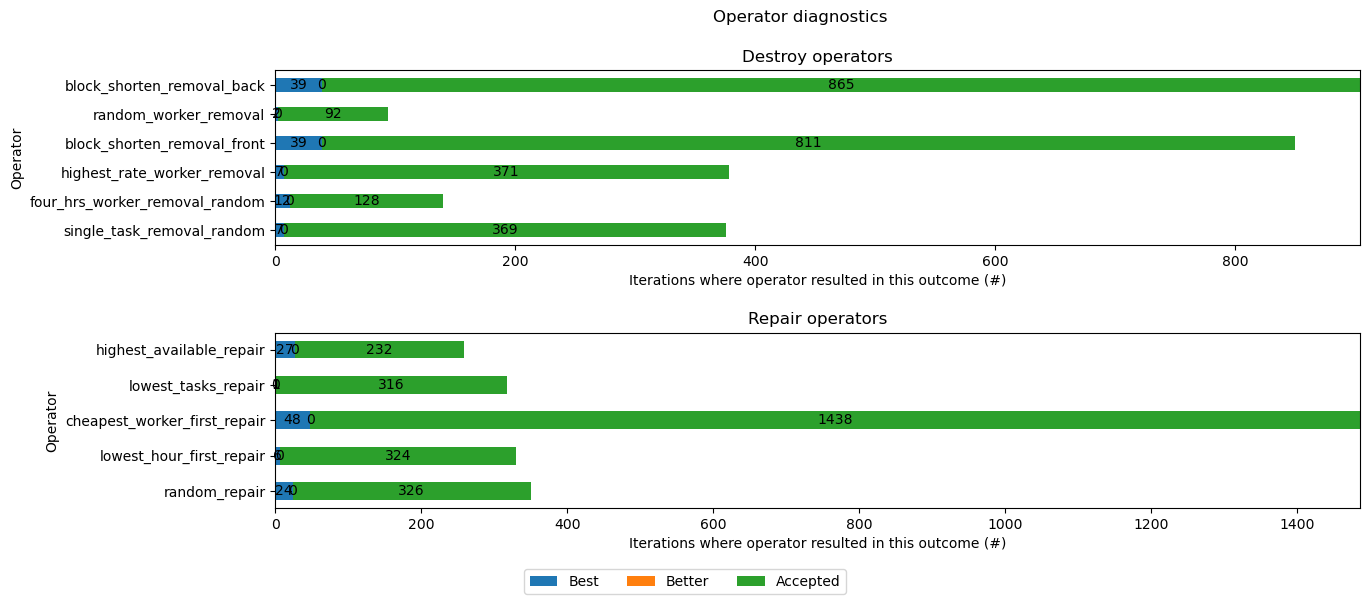

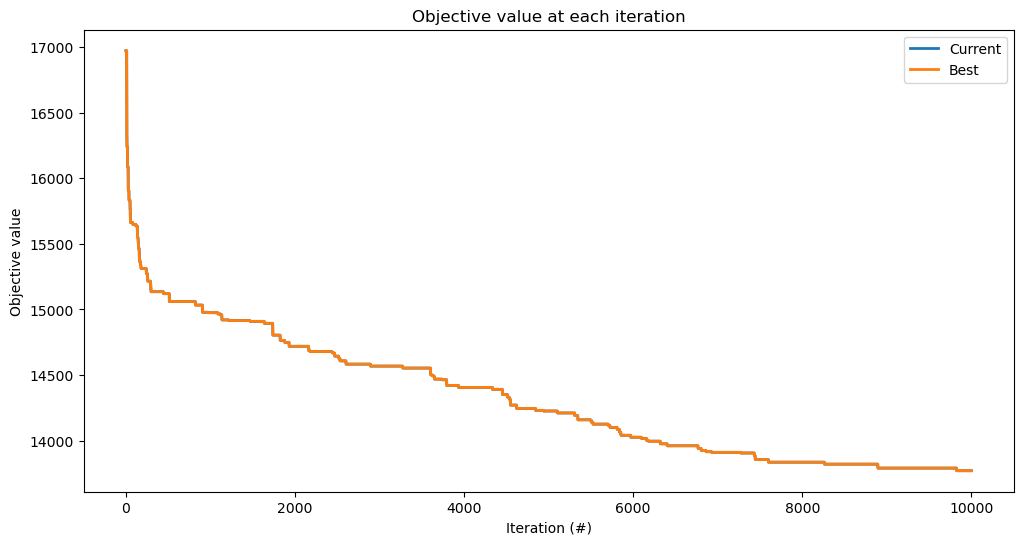

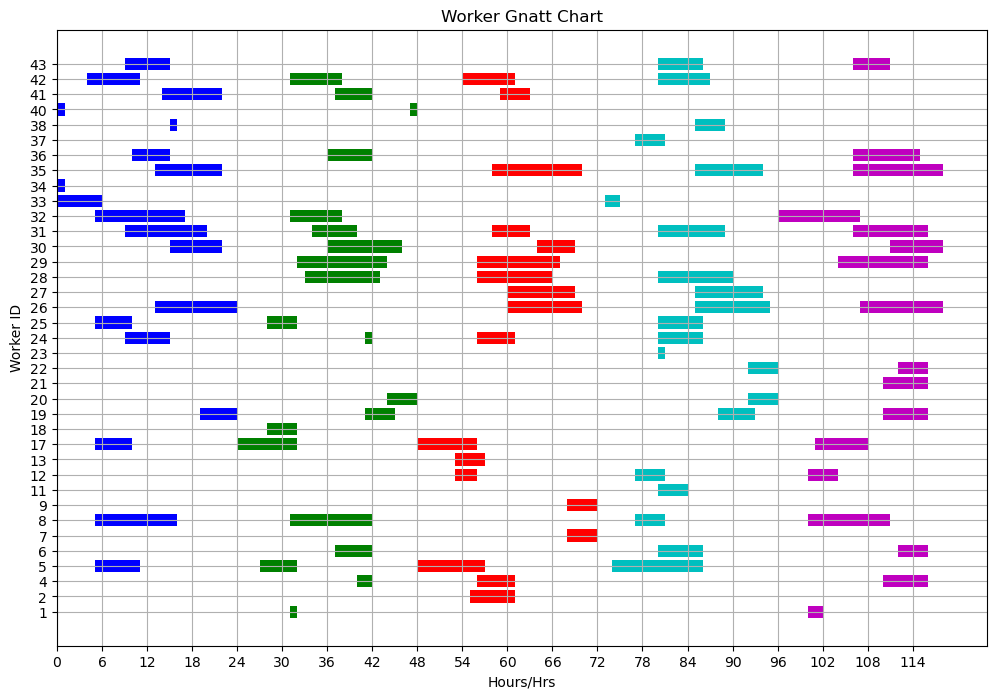

In [1]:
# from IPython.core.debugger import set_trace
import pandas as pd
import matplotlib
import time 

import argparse
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import random
import copy

from gsp import Parser, GSP
from alns import ALNS, State
from alns.criteria import HillClimbing

# %matplotlib inline

### save output file for the solution ###
def save_output(YourName, gsp, suffix):
    '''Generate output file (.txt) for the gsp solution, containing the instance name, the objective value, and the route
    Args:
        YourName::str
            your name, eg. John_Doe
        gsp::GSP
            a GSP object
        suffix::str
            suffix of the output file,
            eg. 'initial' for random initialization
            and 'solution' for the final solution
    '''
    workers = sorted(gsp.workers, key=lambda x:x.id)
    str_builder = [f'Objective: {gsp.objective()}, Unassigned: {[t.id for t in gsp.unassigned]}']
    str_builder += [str(w) for w in workers]
    str_builder = [e for e in str_builder if len(e)>0]
    with open('{}_{}_{}.txt'.format(YourName, gsp.name, suffix), 'w') as f:
        f.write('\n'.join(str_builder))
        

#############################################################################################################
#############################################################################################################

# here i create a class that changes the degree of destruction according to the time elasped. 
class degree():
    
    def __init__(self, start_deg=0.25):
        self.start_time = time.time()
        self.start_deg = start_deg
        self.limit = 0.03
        self.change = self.start_deg - self.limit
        
    def get_deg(self):
        
        time_now = time.time()
        time_passed = time_now - self.start_time
        if time_passed > 170.0:
            time_passed = 170.0
        
        deg = self.limit + self.change*((171-time_passed)/171)   #170
        deg = round(deg,2)
        return deg

#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################

def random_worker_removal(current, random_state):
    global destruct
    """
    Random removal of workers 
    """
    # degree of destruction 
    deg = int(destruct.get_deg()*len(current.workers))
    # at least 1 needs to be selected 
    if deg < 1: 
        deg = 1
    # copy the input  
    gsp_dt = current.copy()
    
    ID = []
    # identify the id of workers that have something assigned
    for x in gsp_dt.workers: 
        if len(x.tasks_assigned) != 0: 
            ID.append(x.id)
    
    # skip the destroy if the number of worker do not satisfy the choice function 
    if len(ID) < deg: 
        return gsp_dt 
    
    # select 3 worker's idx for destruction 
    chosen_idx = random_state.choice(ID, deg, replace=False)
    
    # for deg worker >> repeat deg times 
    for idx in chosen_idx: 
        # return all these task to the unassigned list
        gsp_dt.unassigned = gsp_dt.unassigned + gsp_dt.workers[idx].tasks_assigned
        gsp_dt.workers[idx].tasks_assigned = []
        # reset the blocks dictionary 
        gsp_dt.workers[idx].blocks = {}
        # reset total hours 
        gsp_dt.workers[idx].total_hours = 0
    
#     random_state.shuffle(gsp_dt.unassigned)
#     random_state.shuffle(gsp_dt.unassigned)
    
    return gsp_dt


def highest_rate_worker_removal(current, random_state):
    global destruct
    
    """
    Removal of most expensive worker 
    """
    # degree of destruction 
    deg = int(destruct.get_deg()*len(current.workers))
    # at least 1 needs to be selected 
    if deg < 1: 
        deg = 1
        
    # copy the input  
    gsp_dt = current.copy()
    
    # set the list, get only the workers who have something assigned 
    rates_list = [] 
    for idx in range(len(gsp_dt.workers)):
        if len(gsp_dt.workers[idx].tasks_assigned) == 0: 
            rate = 0 # here we put to 100 as we are not interest in removing such cases 
        else:
            rate = gsp_dt.workers[idx].rate
        
        # append the rate 
        rates_list.append([idx, rate])    
    
    # sort the list with the lowest util at the front 
    rates_list = sorted(rates_list, key=lambda x: x[1], reverse = True)
    
    # skip the destroy if the number of worker do not satisfy number of workers I need to remove 
    if len(rates_list) < deg: 
        return gsp_dt 
    
    # pick top deg of destruction 
    chosen_idx = []
    for x in range(deg):
        chosen_idx.append(rates_list[x][0])
        
    # for deg worker >> repeat deg times 
    for idx in chosen_idx: 
        # return all these task to the unassigned list
        gsp_dt.unassigned = gsp_dt.unassigned + gsp_dt.workers[idx].tasks_assigned
        gsp_dt.workers[idx].tasks_assigned = []
        # reset the blocks dictionary 
        gsp_dt.workers[idx].blocks = {}
        # reset total hours 
        gsp_dt.workers[idx].total_hours = 0
    
    return gsp_dt

def four_hrs_worker_removal_random(current, random_state):
    global destruct
    
    """
    Removal of wokers with less than 4 hours 
    """
    # degree of destruction 
    deg = int(destruct.get_deg()*len(current.workers))
    # at least 1 needs to be selected 
    if deg < 1: 
        deg = 1
        
    # copy the input  
    gsp_dt = current.copy()
    
    blocks_idx = []
    for worker in gsp_dt.workers:
        if len(worker.blocks) != 0: 
            # checks every single block and returns the length 
            check = [x[1] - x[0] for x in worker.blocks.values()]
            # counts the number of times a block is less than 4 slots 
            counts = sum(i < 3 for i in check)
            if counts > 0: 
                blocks_idx.append(worker.id)
                
    # skip the destroy if the number of worker do not satisfy the choice function 
    if len(blocks_idx) < deg: 
        return gsp_dt 
                
    # select worker's idx for destruction 
    chosen_idx = random_state.choice(blocks_idx, deg, replace=False)
    
    # for deg worker >> repeat deg times 
    for idx in chosen_idx: 
        # return all these task to the unassigned list
        gsp_dt.unassigned = gsp_dt.unassigned + gsp_dt.workers[idx].tasks_assigned
        gsp_dt.workers[idx].tasks_assigned = []
        # reset the blocks dictionary 
        gsp_dt.workers[idx].blocks = {}
        # reset total hours 
        gsp_dt.workers[idx].total_hours = 0
    
    return gsp_dt


def single_task_removal_random(current, random_state):
    global destruct
    global max_days
    
    """
    Removal random task 
    """
    # degree of destruction
    deg = int(destruct.get_deg()*len(current.workers))
    # at least 1 needs to be selected 
    if deg < 1: 
        deg = 1
    # copy the input  
    gsp_dt = current.copy()
    
    # set the list
    workers_list = [] 
    for worker in gsp_dt.workers: 
        if len(worker.tasks_assigned) != 0: 
           workers_list.append(worker.id)
        
    # skip the destroy if the number of worker do not satisfy the choice function 
    if len(workers_list) < deg: 
        return gsp_dt 
    
    # choose the lucky workers whom I will randomly remove a single task from 
    chosen_workers = random_state.choice(workers_list, deg, replace=False)
    
    # repeat for all chosen workers 
    for idx in chosen_workers: 
        # get the id of all the tasks 
        task_id_list = [x.id for x in gsp_dt.workers[idx].tasks_assigned]
        # pick the id of just 1 task
        chosen_task = random_state.choice(task_id_list, 1, replace=False)[0]
        # deep copy the task 
        task = copy.deepcopy(gsp_dt.tasks[chosen_task])
        # remove that task
        gsp_dt.workers[idx].remove_task(chosen_task)
        # push the task to unassigned place 
        gsp_dt.unassigned.append(task)
    
    return gsp_dt



def block_shorten_removal_front(current, random_state):
    global destruct
    global max_days
    
    """
    Removal a single task from the front of a random worker 
    """
    # degree of destruction
    deg = int(destruct.get_deg()*len(current.workers))
    # at least 1 needs to be selected 
    if deg < 1: 
        deg = 1
        
    # copy the input  
    gsp_dt = current.copy()
    
    # choose only workers who have tasks assigned 
    workers_list = [] 
    for worker in gsp_dt.workers:
        if len(worker.tasks_assigned) != 0: 
           workers_list.append(worker.id)
        
    # skip the destroy if the number of worker do not satisfy the choice function 
    if len(workers_list) < deg: 
        return gsp_dt   
    
    # choose the lucky workers whom I will randomly remove a single task from 
    chosen_workers = random_state.choice(workers_list, deg, replace=False)
    # repeat for all chosen workers 
    for idx in chosen_workers: 
        # get the days 
        days = gsp_dt.workers[idx].blocks.keys()
        
        #chosen_days 
        chosen_days = []
        
        # identify the days that have blocks longer then 4 
        for day in days:
            length = gsp_dt.workers[idx].blocks[day][1] - gsp_dt.workers[idx].blocks[day][0]
            if length > 3:
                chosen_days.append(day)
        
        # if no one qualifies 
        if len(chosen_days) == 0: 
            pass

        # if someone qualifies 
        else: 
        # choose the day 
            the_day = random_state.choice(chosen_days, 1, replace=False)[0]
            # find the task ID of first hour slot for the day 
            tasks_day = [x for x in gsp_dt.workers[idx].tasks_assigned if x.day == the_day]
            tasks_day = sorted(tasks_day, key=lambda x: x.hour, reverse = False)
            id_remove = tasks_day[0].id
        
            # deep copy the task 
            task = copy.deepcopy(gsp_dt.tasks[id_remove])
            
            # remove that task
            gsp_dt.workers[idx].remove_task(id_remove)
            
            # push the task to unassigned place 
            gsp_dt.unassigned.append(task)
    
    return gsp_dt


def block_shorten_removal_back(current, random_state):
    global destruct
    global max_days
    
    """
    Removal a single task from the back of a random worker 
    """
    # degree of destruction
    deg = int(destruct.get_deg()*len(current.workers))
    # at least 1 needs to be selected 
    if deg < 1: 
        deg = 1
        
    # copy the input  
    gsp_dt = current.copy()
    
    # choose only workers who have tasks assigned 
    workers_list = [] 
    for worker in gsp_dt.workers:
        if len(worker.tasks_assigned) != 0: 
           workers_list.append(worker.id)
        
    # skip the destroy if the number of worker do not satisfy the choice function 
    if len(workers_list) < deg: 
        return gsp_dt  
    
    # choose the lucky workers whom I will randomly remove a single task from 
    chosen_workers = random_state.choice(workers_list, deg, replace=False)
    # repeat for all chosen workers 
    for idx in chosen_workers: 
        # get the days 
        days = gsp_dt.workers[idx].blocks.keys()
        
        #chosen_days 
        chosen_days = []
        
        # identify the days that have blocks longer then 4 
        for day in days:
            length = gsp_dt.workers[idx].blocks[day][1] - gsp_dt.workers[idx].blocks[day][0]
            if length > 3:
                chosen_days.append(day)
        
        # if no one qualifies 
        if len(chosen_days) == 0: 
            pass

        # if someone qualifies 
        else: 
        # choose the day 
            the_day = random_state.choice(chosen_days, 1, replace=False)[0]
            # find the task ID of last hour for the day 
            tasks_day = [x for x in gsp_dt.workers[idx].tasks_assigned if x.day == the_day]
            tasks_day = sorted(tasks_day, key=lambda x: x.hour, reverse = True)
            id_remove = tasks_day[0].id
        
            # deep copy the task 
            task = copy.deepcopy(gsp_dt.tasks[id_remove])
            
            # remove that task
            gsp_dt.workers[idx].remove_task(id_remove)
            
            # push the task to unassigned place 
            gsp_dt.unassigned.append(task)
    
    return gsp_dt


#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################


def cheapest_worker_first_repair(current, random_state):
    """
    Greedily repairs by arranging the workers from the cheapest to the most costly 
    """
    # copy the input  
    gsp_rp = current.copy()
    
    # sort the workers by the rates, lowest first 
    gsp_rp.workers = sorted(gsp_rp.workers, key=lambda x: x.rate)
    
    # deepcopy the current un assigned task 
    task_list = copy.deepcopy(gsp_rp.unassigned)
    
    # randomise the copied task list 
    random_state.shuffle(task_list)
    
    # empty the self.unassigned 
    gsp_rp.unassigned = []
    
    count = 0 
    # while copied list is not empty: 
    while len(task_list) != 0:
        # for tracing 
        count += 1
        if count == 50: 
            pass
        current_task = task_list.pop(0)
        # for every worker available
        for idx in range(len(gsp_rp.workers)): 
            # try to assign 
            result = gsp_rp.workers[idx].can_assign(current_task)
            # if possible to assign
            if result == True: 
                # assign 
                gsp_rp.workers[idx].assign_task(current_task)
                # exit the for loop 
                break
                
        # no match was found, append to the unassigned list       
        if result == False:
            gsp_rp.unassigned.append(current_task)
            
    # sort the worker by ID once more 
    gsp_rp.workers = sorted(gsp_rp.workers, key=lambda x: x.id)
    
    return gsp_rp


def lowest_hour_first_repair(current, random_state):
    """
    Greedily repairs by arranging the workers with lowest total hours at the top 
    """
    # copy the input  
    gsp_rp = current.copy()
    
    # sort the workers 
    gsp_rp.workers = sorted(gsp_rp.workers, key=lambda x: x.total_hours, reverse = False)
    
    # deepcopy the current un assigned task 
    task_list = copy.deepcopy(gsp_rp.unassigned)
    
    # randomise the copied task list 
    random_state.shuffle(task_list)
    
    # empty the self.unassigned 
    gsp_rp.unassigned = []
    
    count = 0 
    # while copied list is not empty: 
    while len(task_list) != 0:
        current_task = task_list.pop(0)
        # for every worker available
        for idx in range(len(gsp_rp.workers)): 
            # try to assign 
            result = gsp_rp.workers[idx].can_assign(current_task)
            # if possible to assign
            if result == True: 
                # assign 
                gsp_rp.workers[idx].assign_task(current_task)
                # exit the for loop 
                break
                
        # no match was found, append to the unassigned list       
        if result == False:
            gsp_rp.unassigned.append(current_task)
            
    # sort the worker by ID once more 
    gsp_rp.workers = sorted(gsp_rp.workers, key=lambda x: x.id)
    
    return gsp_rp

def lowest_tasks_repair(current, random_state):
    """
    Greedily repairs by arranging the workers with lowest number of task on top 
    """
    # copy the input  
    gsp_rp = current.copy()
    
    # sort the workers 
    gsp_rp.workers = sorted(gsp_rp.workers, key=lambda x: len(x.tasks_assigned), reverse = False)
    
    # deepcopy the current un assigned task 
    task_list = copy.deepcopy(gsp_rp.unassigned)
    
    # randomise the copied task list 
    random_state.shuffle(task_list)
    
    # empty the self.unassigned 
    gsp_rp.unassigned = []
    
    count = 0 
    # while copied list is not empty: 
    while len(task_list) != 0:
        # for tracing 
        count += 1
        if count == 50: 
            pass
        current_task = task_list.pop(0)
        # for every worker available
        for idx in range(len(gsp_rp.workers)): 
            # try to assign 
            result = gsp_rp.workers[idx].can_assign(current_task)
            # if possible to assign
            if result == True: 
                # assign 
                gsp_rp.workers[idx].assign_task(current_task)
                # exit the for loop 
                break
                
        # no match was found, append to the unassigned list       
        if result == False:
            gsp_rp.unassigned.append(current_task)
            
    # sort the worker by ID once more 
    gsp_rp.workers = sorted(gsp_rp.workers, key=lambda x: x.id)
    
    return gsp_rp


def highest_available_repair(current, random_state):
    """
    Greedily repairs by arranging the workers with highest available hours on top 
    """
    # copy the input  
    gsp_rp = current.copy()
    
    # sort the workers by the hours available 
    gsp_rp.workers = sorted(gsp_rp.workers, key=lambda x: sum([x[1]-x[0] for x in x.available.values()]), reverse = True)
    
    # deepcopy the current un assigned task 
    task_list = copy.deepcopy(gsp_rp.unassigned)
    
    # randomise the copied task list 
    random_state.shuffle(task_list)
    
    # empty the self.unassigned 
    gsp_rp.unassigned = []
    
    count = 0 
    # while copied list is not empty: 
    while len(task_list) != 0:
        current_task = task_list.pop(0)
        # for every worker available
        for idx in range(len(gsp_rp.workers)): 
            # try to assign 
            result = gsp_rp.workers[idx].can_assign(current_task)
            # if possible to assign
            if result == True: 
                # assign 
                gsp_rp.workers[idx].assign_task(current_task)
                # exit the for loop 
                break
                
        # no match was found, append to the unassigned list       
        if result == False:
            gsp_rp.unassigned.append(current_task)
            
    # sort the worker by ID once more 
    gsp_rp.workers = sorted(gsp_rp.workers, key=lambda x: x.id)
    
    return gsp_rp

def random_repair(current, random_state):
    """
    repairs by randomly arranging the workers
    """
    # copy the input  
    gsp_rp = current.copy()
    
    # sort the workers by the rates, lowest first 
    random_state.shuffle(gsp_rp.workers)
    
    # deepcopy the current un assigned task 
    task_list = copy.deepcopy(gsp_rp.unassigned)
    
    # randomise the copied task list 
    random_state.shuffle(task_list)
    
    # empty the self.unassigned 
    gsp_rp.unassigned = []
    
    # while copied list is not empty: 
    while len(task_list) != 0:
        current_task = task_list.pop(0)
        # for every worker available
        for idx in range(len(gsp_rp.workers)): 
            # try to assign 
            result = gsp_rp.workers[idx].can_assign(current_task)
            # if possible to assign
            if result == True: 
                # assign 
                gsp_rp.workers[idx].assign_task(current_task)
                # exit the for loop 
                break
                
        # no match was found, append to the unassigned list       
        if result == False:
            gsp_rp.unassigned.append(current_task)
            
    # sort the worker by ID once more 
    gsp_rp.workers = sorted(gsp_rp.workers, key=lambda x: x.id)
    
    return gsp_rp

#     parser = argparse.ArgumentParser(description='load data')
#     parser.add_argument(dest='data', type=str, help='data')
#     parser.add_argument(dest='seed', type=int, help='seed')
#     args = parser.parse_args()

#     # instance file and random seed
#     json_file = args.data
#     seed = int(args.seed)

#     # load data and random seed
#     parsed = Parser(json_file)

# instance file and random seed
json_file = 'S3_in.json'
seed = 89757

# load data and random seed
parsed = Parser(json_file)
gsp = GSP(parsed.name, parsed.workers, parsed.tasks, parsed.Alpha)

# construct random initialized solution
gsp.random_initialize(seed)

print("Initial solution objective is {}.".format(gsp.objective()))

# ALNS
random_state = rnd.RandomState(seed)
alns = ALNS(random_state)

destruct = degree()
max_days = parsed.T

start = time.time() 

# add destroy
# You should add all your destroy and repair operators
alns.add_destroy_operator(random_worker_removal) # random removal of a worker schedule totally  
alns.add_destroy_operator(highest_rate_worker_removal) # removes the workers with highest rates (target expensive)
alns.add_destroy_operator(four_hrs_worker_removal_random) # removes any worker with blocks < 4 hrs (target singular task)
alns.add_destroy_operator(single_task_removal_random) # removes a single task from worker(>T) (maybe goodfor fine tuning)
alns.add_destroy_operator(block_shorten_removal_front) # removes a single task from the first hour of worker block 
alns.add_destroy_operator(block_shorten_removal_back) # removes a single task from the last hour of worker block 

# add repair
alns.add_repair_operator(cheapest_worker_first_repair) # cheapest at the top 
alns.add_repair_operator(lowest_hour_first_repair) # lowest total hours at the top (target gaps)
alns.add_repair_operator(lowest_tasks_repair) # lowest number of tasks at the top 
alns.add_repair_operator(highest_available_repair) # highest availablility worker at top (target flexibility)
alns.add_repair_operator(random_repair) # random 

# run ALNS
# select cirterion
criterion = HillClimbing()

# assigning weights to methods
result = alns.iterate(gsp, [100, 14, 4, 1], 0.3, criterion, iterations=10000, collect_stats=True)

solution = result.best_state
objective = solution.objective()

elapsed = (time.time() - start)
print('Time taken:', elapsed)
print("Final solution objective is {}.".format(solution.objective()))

#####################################################################################################
#####################################################################################################

# plotting the operator statistics 
figure = plt.figure("operator_counts", figsize=(14, 6))
figure.subplots_adjust(bottom=0.15, hspace=.5)
result.plot_operator_counts(figure=figure, title="Operator diagnostics", legend=["Best", "Better", "Accepted"])
plt.savefig("operator_diagnostic.jpg")

# plotting the search progress 
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax, lw=2)
plt.savefig("search_progress.jpg")

# plotting the gnatt chart 
final_dict = {'worker':[],
              'start':[],
              'end':[],
              'width':[],
              'color':[],
              'day':[]}
my_color = ['b', 'g', 'r', 'c', 'm']

for worker in solution.workers:
    if len(worker.blocks) != 0:
        days = worker.blocks.keys()
        for day in days: 
            final_dict['worker'].append(str(worker.id))
            start_day = ((24*day)-1) + worker.blocks[day][0] + 1
            end_day = ((24*day)-1) + worker.blocks[day][1] + 1
            final_dict['start'].append(start_day)
            final_dict['end'].append(end_day)
            final_dict['width'].append(end_day-start_day+1)
            final_dict['color'].append(my_color[day])
            final_dict['day'].append(day)

df = pd.DataFrame(final_dict)
chart = plt.figure(figsize=(12,8))
plt.barh(y=df['worker'], width=df['width'], left=df['start'], color=df['color'])
plt.xlabel("Hours/Hrs")
plt.xticks(range(0, (parsed.T*24)-1, 6))
plt.ylabel("Worker ID")
plt.title("Worker Gnatt Chart")
plt.grid()
plt.savefig("gnatt_chart.jpg")
plt.show()

# visualize final solution and generate output file
save_output('Licheng_Yan', solution, 'solution')
